# Assessment 2 
During the covid pandemic, governments tried to predict the levels of infection so that they could manage the required infrastructure, especially hospital beds and (sadly) mortuary places. In this mini-project, you will take data from two different, publicly available, sources and try to see how well you could have done if you had been working for the UK government.  One of the sources is the UK data from the period and the other is google’s data on our behaviour during the pandemic.

You will use data up to a specific date to predict hospital beds needed, and deaths that will occur  in one, two, three and four weeks from that date.  You will do this for the whole pandemic period i.e. using a rolling  window. You will also quantify how well your prediction works.

_Notes:_

_AI used to make tables more visually appealing, generate docstrings, and format analyses and comments for aesthetic reasons._

_Did not use a test set, unfortunately noticed this too late and didn't have time to implement before the deadline._

## 1. Setup

In [1]:
import pandas as pd
import datetime as dt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import matplotlib.pylab as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
#Show plots inline
%matplotlib inline

#Some date formatters to use for plotting 
weeks = mdates.WeekdayLocator()
years = mdates.YearLocator()
months = mdates.MonthLocator()
weekdays = mdates.DayLocator()
dateFmt = mdates.DateFormatter('%b-%y')

In [2]:
#seaborn is a useful package for handling graphics and 
#producing publication quality images with better colour schemes
import seaborn as sns
sns.set()
sns.set_style("white")
sns.set_context("talk")
#sns.set(font_scale=1.5) 
#sns.set_context("poster")

plt.rcParams.update({'font.size': 32})
plt.rcParams.update({'lines.linewidth':3})

## 2. Predictors

In principle, covid cases, hospital admissions, and deaths are time-lagged outcomes of covariates or "predictor variables" such as the level of interactions in the population, mobility metrics, levels of restrictions etc.

A data set which is often used as a possible predictor is google mobility metrics https://www.google.com/covid19/mobility/.

In [3]:
#Import the data from Google.
#This is a large file!
df_google_main = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv')

/tmp/ipykernel_8264/4230773577.py:3: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_google_main = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv')


In [4]:
#Select `United Kingdom` from the full data.
df_google = df_google_main[df_google_main['country_region']=='United Kingdom'].copy()
#Discard sub regions
#Note - we England vs UK
df_google = df_google[df_google['sub_region_1'].isnull()]

In [5]:
#Re-index by data
df_google.set_index(pd.to_datetime(df_google['date']),inplace=True)
df_google.sort_index(inplace=True)
df_google.columns

Index(['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2',
       'metro_area', 'iso_3166_2_code', 'census_fips_code', 'place_id', 'date',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')

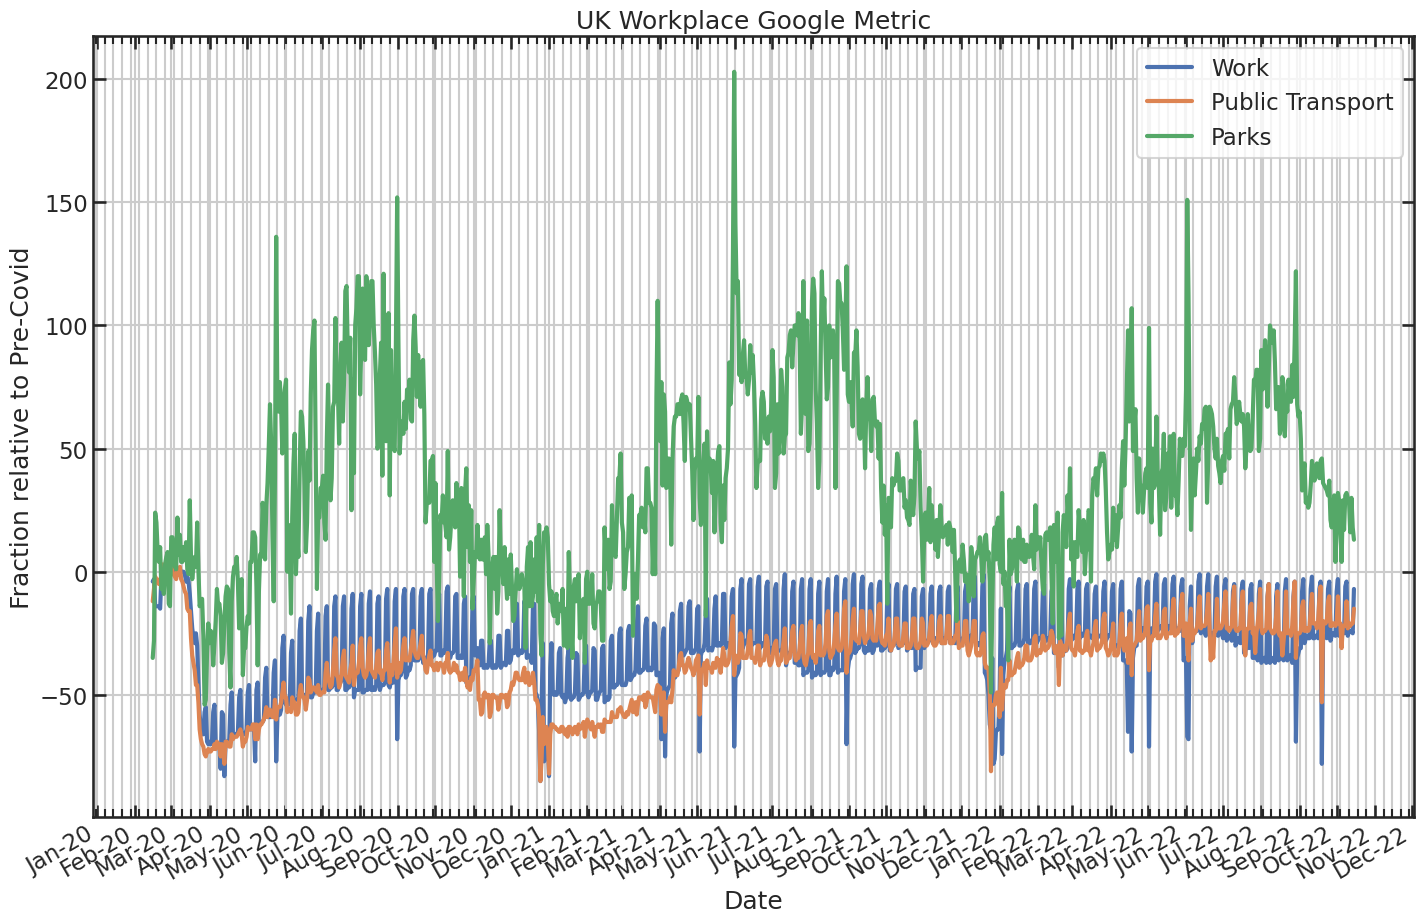

In [6]:
fig, ax = plt.subplots(figsize=(15,10),sharex= True, facecolor='white')

ax.plot(df_google.index,df_google['workplaces_percent_change_from_baseline'],label='Work')
ax.plot(df_google.index,df_google['transit_stations_percent_change_from_baseline'],label='Public Transport')
ax.plot(df_google.index,df_google['parks_percent_change_from_baseline'],label='Parks')


ax.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)


ax.grid(which='both')
ax.set_xlabel('Date')
ax.set_ylabel('Fraction relative to Pre-Covid')

# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFmt)
ax.xaxis.set_minor_locator(weeks)
#ax.set_xlim(left=dt.datetime(2021,7,1))
ax.set_title('UK Workplace Google Metric')
ax.legend()

_= fig.autofmt_xdate()

plt.tight_layout()
plt.savefig('mobility.png')

## The UK data from the covid period.

The UK data is available as a zip file from:

https://ukhsa-dashboard.data.gov.uk/covid-19-archive-data-download

this then needs to be unzipped 
```console
unzip  covid-19-archive.zip
```
This should produce a series of directories:
```console
drwxr-xr-x. 1 collngdj collngdj        126 Oct 25 16:08 Cases
-rw-r--r--. 1 collngdj collngdj 1592889236 Oct 25 16:07 covid-19-archive.zip
drwxr-xr-x. 1 collngdj collngdj        126 Oct 25 16:08 Deaths
drwxr-xr-x. 1 collngdj collngdj        126 Oct 25 16:08 Healthcare
drwxr-xr-x. 1 collngdj collngdj        126 Oct 25 16:08 Testing
drwxr-xr-x. 1 collngdj collngdj        126 Oct 25 16:08 Vaccinations
```

each of these has a set of csv files arranged over different years.

The following code is an example of how you might want to read these in and concatinate them over different years.

_Note: pathlib.Path() changed to pathlib.Path("covid-19-archive") in order to be able to use the folder correctly._


In [7]:
import re
from enum import StrEnum, auto
import pathlib
import pandas as pd

class DataType(StrEnum):
    Cases = auto()
    Deaths = auto()
    Healthcare = auto()
    Testing = auto()
    Vaccinations = auto()


def csvconcat(datatype: DataType,
              metric: str | None = None,
              dataroot: str | pathlib.Path = pathlib.Path("covid-19-archive")) -> dict[str, pd.DataFrame]:
    """
    Get Pandas DataFrames from the UK COVID-19 .csv data, Concatenated across years.

    Args:
        datatype (DataType): Corresponds to the directory to scan use enum type above.
                             i.e. [DataType.Cases|DataType.Deaths|DataType.Healthcare|
                                   DataType.Testing|DataType.Vaccinations]
        metric (str | None, optional): Chose an individual metric to process. If None (the default) then all
                                       metrics for the given DataType are processed. Defaults to None.
        dataroot (pathlib.Path, optional): The root directory for the unpacked UK COVID-19 data.
                                           DataType directories (Cases/Deaths) etc should be under this root.
                                           Defaults to pathlib.Path.cwd().
    Raises:
        ValueError: If there is a failure to convert the given dataroot to a Path object.

    Returns:
        dict[str, pd.DataFrame]: The mapping from metric to fully concatenated DataFrame.
    """
    if not isinstance(dataroot, pathlib.Path):
        try:
            dataroot = pathlib.Path(dataroot)
        except:
            raise ValueError(f"dataroot: '{dataroot}' could not be converted to a Path.")

    dataroot /= datatype.name
    # metric_regex = re.compile(r"(?P<metric>\w+?)_(?P<specifier>nation|region|utla|ltla|overview)_20\d\d.csv")
    metric_regex = re.compile(r"(?P<specifier>nation|region|nhsRegion|nhsTrust|utla|ltla|msoa|overview)_(?P<metric>\w+?).csv")
    metrics: set[str] = {str(metric)}
    if metric is None:
        file_list = (file_.relative_to(dataroot).name for file_ in dataroot.rglob("*.csv"))
        metrics = {match.group("metric") for file_ in file_list if (match := metric_regex.match(file_))}

    ret = {}
    for current_metric in metrics:
        ret.update({current_metric: pd.concat(pd.read_csv(file_) for file_ in dataroot.rglob(f"*_{current_metric}.csv"))})
        # ret.update({current_metric: pd.concat(pd.read_csv(file_) for file_ in dataroot.rglob(f"{current_metric}_*.csv"))})

    return ret



## Data Preprocessing Pipeline

In [70]:
# Load target metrics
df_cases = csvconcat(DataType.Healthcare, "hospitalCases")['hospitalCases']
df_deaths = csvconcat(DataType.Deaths, "newDailyNsoDeathsByDeathDate")['newDailyNsoDeathsByDeathDate']
df_vaccinations = csvconcat(DataType.Vaccinations, "newPeopleVaccinatedCompleteByVaccinationDate")['newPeopleVaccinatedCompleteByVaccinationDate']

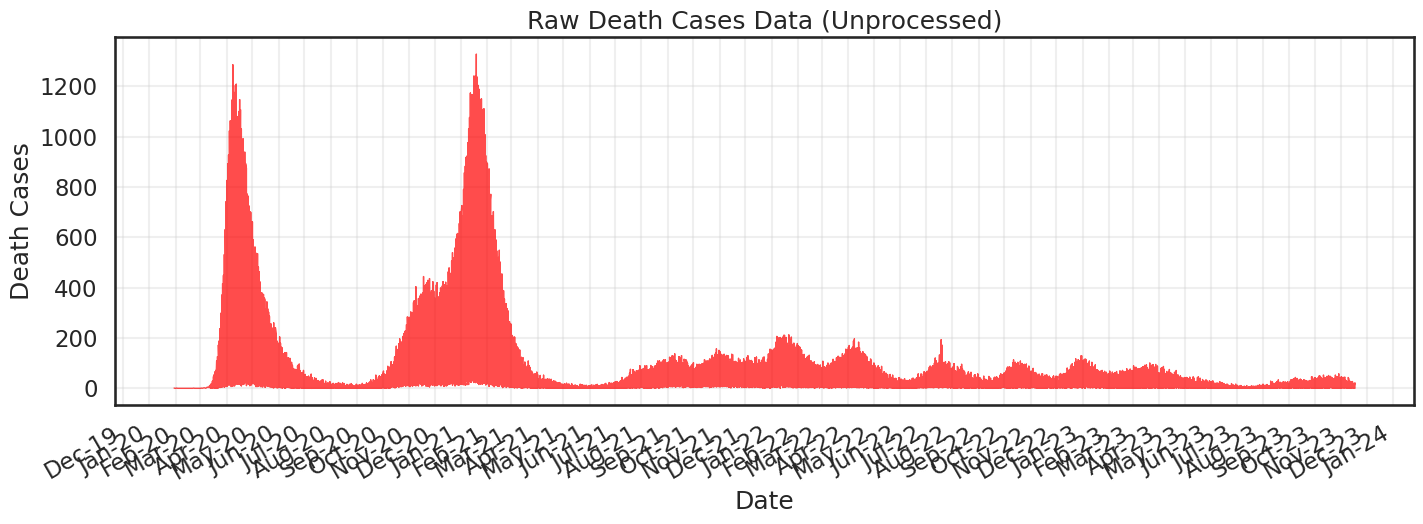

In [71]:
# Plot raw hospital cases data
uk_raw = df_deaths[df_deaths['area_type'] == 'nation'].copy()
uk_raw['date'] = pd.to_datetime(uk_raw['date'])
uk_raw = uk_raw.sort_values('date')

# Plot
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(uk_raw['date'], uk_raw['value'], linewidth=1, color='red', alpha=0.7)
ax.set_xlabel('Date')
ax.set_ylabel('Death Cases')
ax.set_title('Raw Death Cases Data (Unprocessed)')
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFmt)
ax.xaxis.set_minor_locator(weeks)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## 2.1 Raw Data Quality Issues

Visual inspection of the raw COVID-19 data reveals three key problems requiring preprocessing:

**1. Missing Values**  
Gaps exist in the hospital cases and deaths data due to reporting delays (weekends, bank holidays) and retrospective corrections. **Solution:** Time-based interpolation to fill gaps.

**2. Weekend Effects**  
The raw data shows pronounced weekly patterns with drops at weekends and spikes on Mondays/Tuesdays as backfilled data arrives, creating artificial volatility. **Solution:** 14-day rolling average to smooth weekly reporting artefacts whilst preserving genuine trends.

**3. Inconsistent Date Ranges**  
Data sources cover different periods:
- Google mobility: Feb 2020 – Oct 2022
- Hospital cases: Apr 2020 onwards (gaps in late 2022)
- Deaths: Mar 2020 onwards (reporting ceased 2022)
- Vaccinations: Dec 2020 onwards (rollout start)

**Solution:** Align all datasets to common date range (2020-04-02 to 2022-10-15), zero-filling where appropriate (pre-vaccination dates, late reporting gaps).

In [72]:
# Format targets (UK only, set index)
uk_cases = df_cases[df_cases['area_type'] == 'nation'].copy()
uk_cases['date'] = pd.to_datetime(uk_cases['date'])
uk_cases = uk_cases.set_index('date')[['value']].sort_index()
uk_cases = uk_cases[~uk_cases.index.duplicated(keep='first')]

uk_deaths = df_deaths[df_deaths['area_type'] == 'nation'].copy()
uk_deaths['date'] = pd.to_datetime(uk_deaths['date'])
uk_deaths = uk_deaths.set_index('date')[['value']].sort_index()
uk_deaths = uk_deaths[~uk_deaths.index.duplicated(keep='first')]

uk_vaccinations = df_vaccinations[df_vaccinations['area_type'] == 'nation'].copy()
uk_vaccinations['date'] = pd.to_datetime(uk_vaccinations['date'])
uk_vaccinations = uk_vaccinations.set_index('date')[['value']].sort_index()
uk_vaccinations = uk_vaccinations[~uk_vaccinations.index.duplicated(keep='first')]

print("Hospital Cases:")
print(uk_cases.head())
print("\nDeaths:")
print(uk_deaths.head())
print("\nVaccinations:")
print(uk_vaccinations.head())

Hospital Cases:
            value
date             
2020-03-01   11.0
2020-03-02   12.0
2020-03-03   12.0
2020-03-04   12.0
2020-03-05   13.0

Deaths:
            value
date             
2020-01-30    1.0
2020-01-31    0.0
2020-02-01    0.0
2020-02-02    1.0
2020-02-03    0.0

Vaccinations:
            value
date             
2020-12-08  153.0
2020-12-09  145.0
2020-12-10    1.0
2020-12-11    2.0
2020-12-12    1.0


### Data Alignment and Cleaning

In [73]:

# Trim all data to common date range (use cases/deaths start, not vaccinations)
common_start = max(df_google.index.min(), uk_cases.index.min(), uk_deaths.index.min())
common_end = df_google.index.max()  # Use Google mobility end date as the full range

df_google = df_google.loc[common_start:common_end]

# Extend cases and deaths to full range, filling missing end values with 0
full_date_range = pd.date_range(common_start, common_end, freq='D')
uk_cases = uk_cases.reindex(full_date_range).fillna(0)
uk_deaths = uk_deaths.reindex(full_date_range).fillna(0)

# Reindex vaccinations to full date range and fill early values (before rollout) with 0
uk_vaccinations = uk_vaccinations.reindex(full_date_range).fillna(0)

print(f"Common date range: {common_start.date()} to {common_end.date()}")
print(f"Google mobility: {len(df_google)} days")
print(f"Hospital cases: {len(uk_cases)} days (zeros filled for end dates)")
print(f"Deaths: {len(uk_deaths)} days (zeros filled for end dates)")
print(f"Vaccinations: {len(uk_vaccinations)} days (zeros filled for early dates)")

Common date range: 2020-03-01 to 2022-10-15
Google mobility: 959 days
Hospital cases: 959 days (zeros filled for end dates)
Deaths: 959 days (zeros filled for end dates)
Vaccinations: 959 days (zeros filled for early dates)


### Interpolation and Smoothing

In [74]:
# Interpolate COVID data to fill gaps
uk_cases_interp = uk_cases.interpolate(method='time')
uk_deaths_interp = uk_deaths.interpolate(method='time')
uk_vaccinations_interp = uk_vaccinations.interpolate(method='time')

print("Interpolated hospital cases:")
print(uk_cases_interp.head())
print(f"\nMissing values in cases: {uk_cases_interp.isnull().sum().sum()}")
print(f"Missing values in deaths: {uk_deaths_interp.isnull().sum().sum()}")
print(f"Missing values in vaccinations: {uk_vaccinations_interp.isnull().sum().sum()}")

Interpolated hospital cases:
            value
2020-03-01   11.0
2020-03-02   12.0
2020-03-03   12.0
2020-03-04   12.0
2020-03-05   13.0

Missing values in cases: 0
Missing values in deaths: 0
Missing values in vaccinations: 0


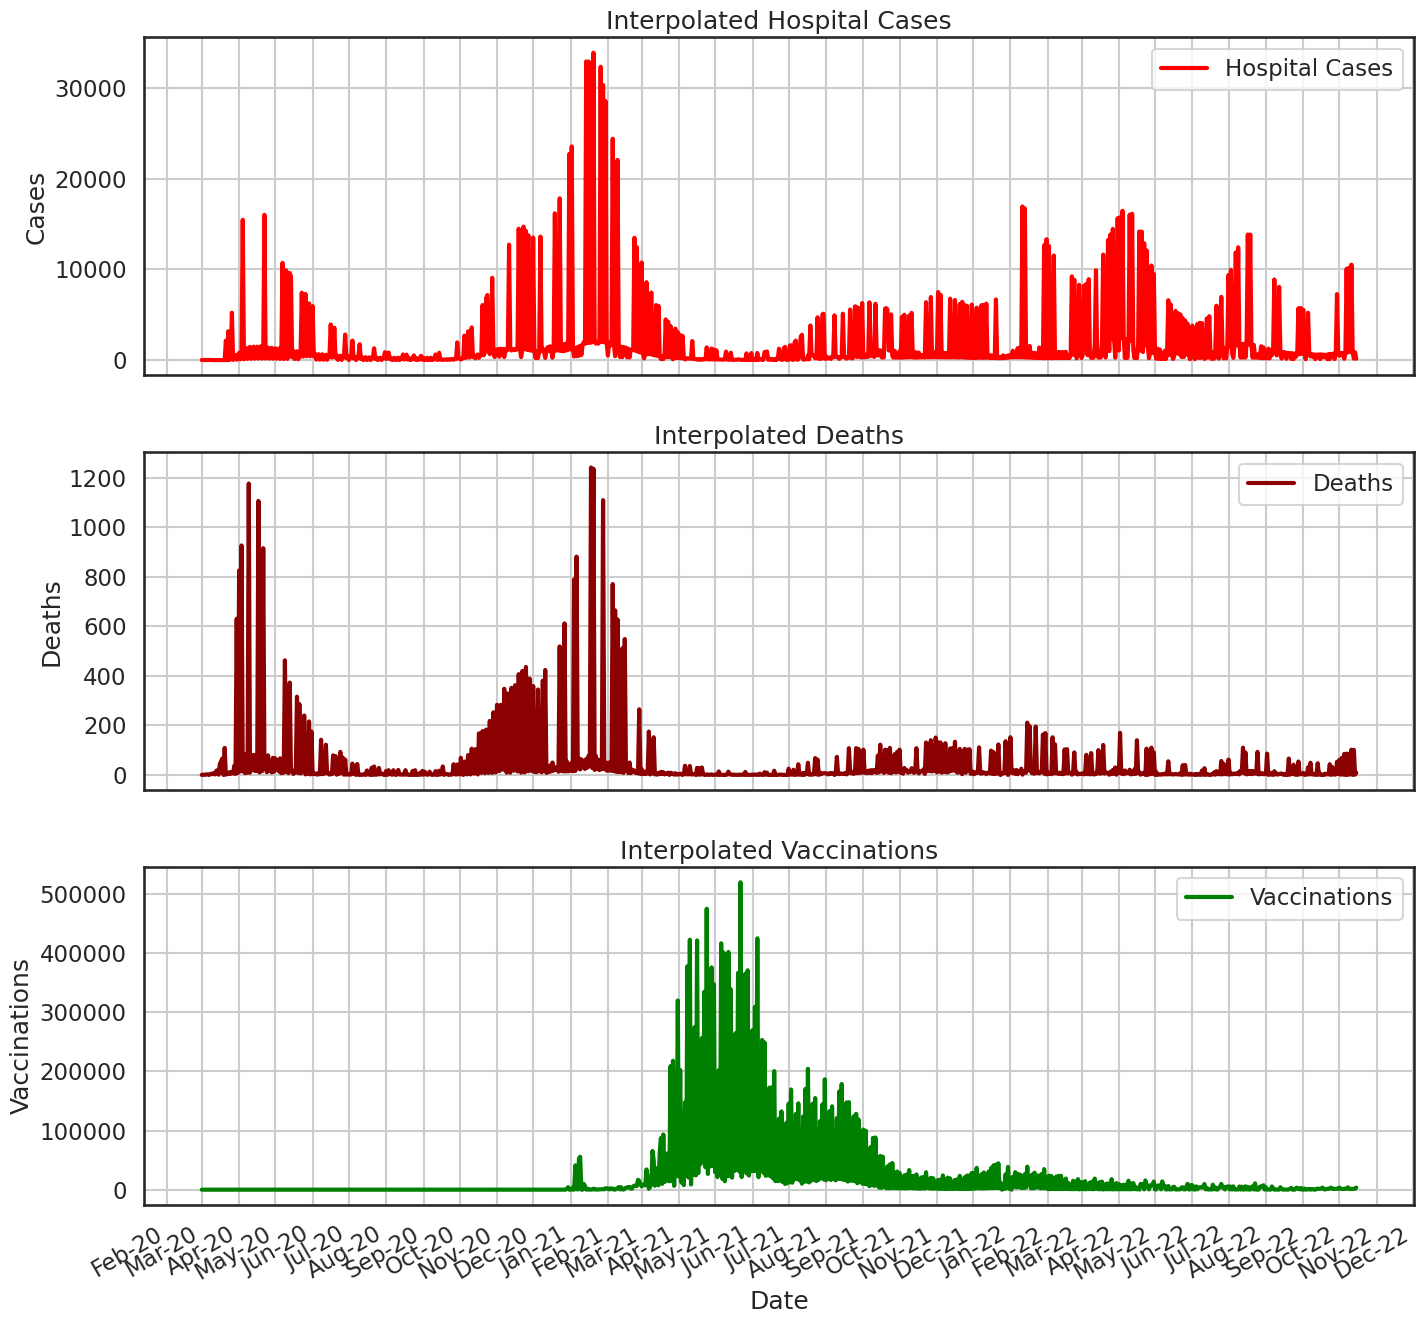

In [75]:
# Plot interpolated COVID data
fig, axes = plt.subplots(3, 1, figsize=(15, 14))

axes[0].plot(uk_cases_interp.index, uk_cases_interp['value'], label='Hospital Cases', color='red')
axes[0].set_title('Interpolated Hospital Cases')
axes[0].set_ylabel('Cases')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(uk_deaths_interp.index, uk_deaths_interp['value'], label='Deaths', color='darkred')
axes[1].set_title('Interpolated Deaths')
axes[1].set_ylabel('Deaths')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(uk_vaccinations_interp.index, uk_vaccinations_interp['value'], label='Vaccinations', color='green')
axes[2].set_title('Interpolated Vaccinations')
axes[2].set_ylabel('Vaccinations')
axes[2].set_xlabel('Date')
axes[2].legend()
axes[2].grid(True)

# format the ticks for all subplots
for ax in axes:
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(dateFmt)
    ax.xaxis.set_minor_locator(weeks)

_ = fig.autofmt_xdate()

plt.tight_layout()
plt.show()

In [76]:
# Apply smoothing to COVID data (14-day rolling average)
uk_cases_smooth = uk_cases_interp.rolling(window=14).mean().dropna()
uk_deaths_smooth = uk_deaths_interp.rolling(window=14).mean().dropna()
uk_vaccinations_smooth = uk_vaccinations_interp.rolling(window=14).mean().dropna()

print(f"Smoothed cases shape: {uk_cases_smooth.shape}")
print(f"Smoothed deaths shape: {uk_deaths_smooth.shape}")
print(f"Smoothed vaccinations shape: {uk_vaccinations_smooth.shape}")
print("\nSmoothed hospital cases head:")
print(uk_cases_smooth.head())

Smoothed cases shape: (946, 1)
Smoothed deaths shape: (946, 1)
Smoothed vaccinations shape: (946, 1)

Smoothed hospital cases head:
               value
2020-03-14  9.785714
2020-03-15  9.142857
2020-03-16  8.500000
2020-03-17  7.714286
2020-03-18  6.857143


In [77]:
# Define predictor columns
predictor_cols = ['retail_and_recreation_percent_change_from_baseline',
                  'grocery_and_pharmacy_percent_change_from_baseline',
                  'parks_percent_change_from_baseline',
                  'transit_stations_percent_change_from_baseline',
                  'workplaces_percent_change_from_baseline',
                  'residential_percent_change_from_baseline']

print(f"Using {len(predictor_cols)} mobility predictors")

Using 6 mobility predictors


In [78]:
# Apply smoothing to mobility data (14-day rolling average)
df_google_smooth = df_google[predictor_cols].rolling(window=14).mean().dropna()

print(f"Smoothed mobility data shape: {df_google_smooth.shape}")
print("\nSmoothed mobility data head:")
print(df_google_smooth.head())

Smoothed mobility data shape: (946, 6)

Smoothed mobility data head:
            retail_and_recreation_percent_change_from_baseline  \
date                                                             
2020-03-14                                           0.571429    
2020-03-15                                          -0.714286    
2020-03-16                                          -1.214286    
2020-03-17                                          -2.428571    
2020-03-18                                          -4.071429    

            grocery_and_pharmacy_percent_change_from_baseline  \
date                                                            
2020-03-14                                           4.785714   
2020-03-15                                           5.142857   
2020-03-16                                           6.285714   
2020-03-17                                           7.571429   
2020-03-18                                           8.928571   

            

### Visual Inspection of Processed Data

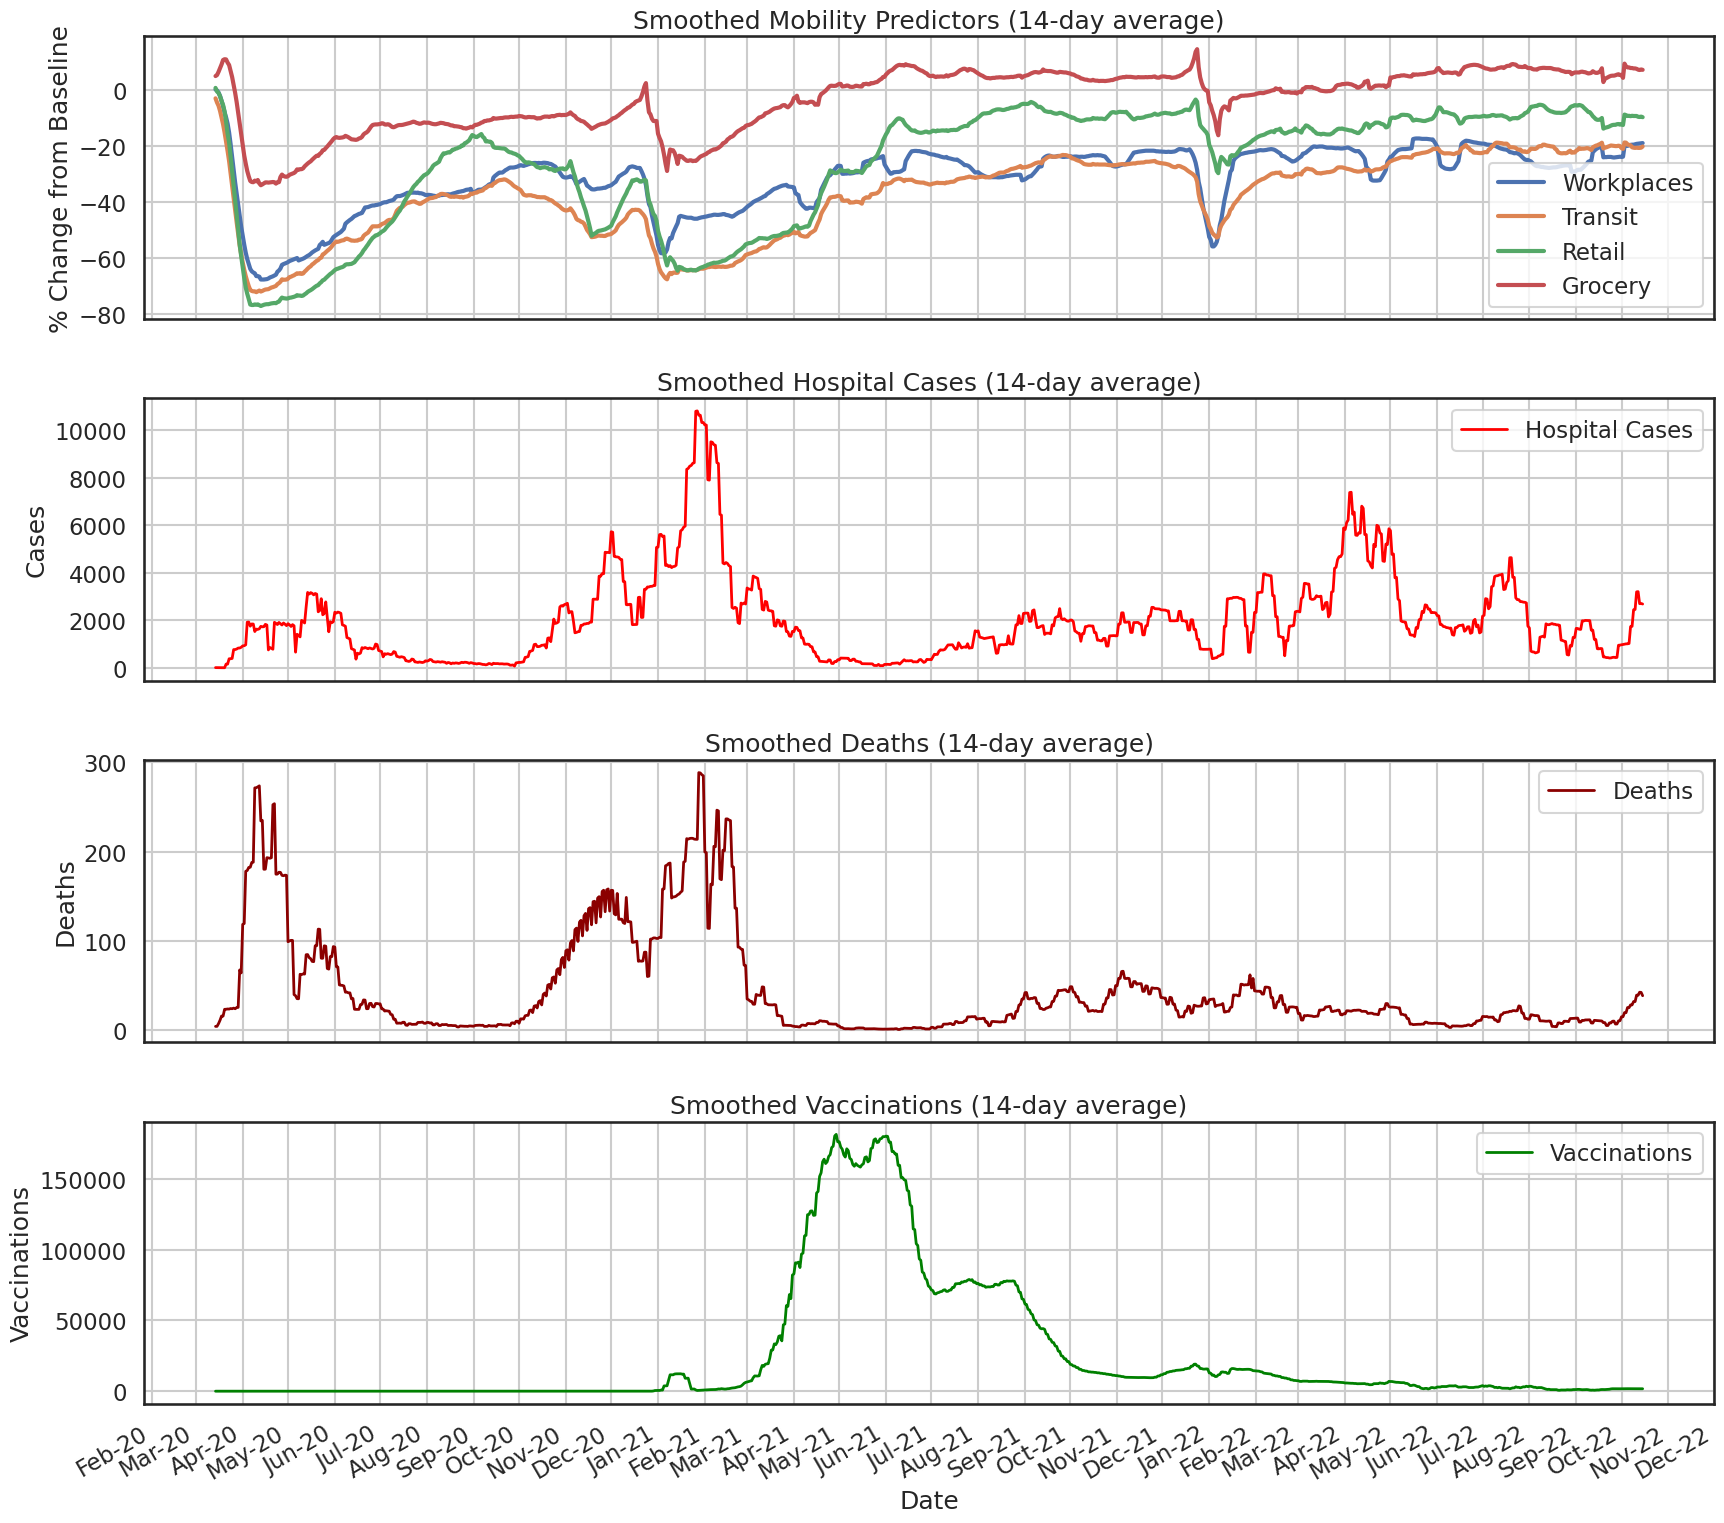

In [79]:
# Plot smoothed mobility and targets together for visual inspection
fig, axes = plt.subplots(4, 1, figsize=(18, 16))

# Plot all mobility predictors
axes[0].plot(df_google_smooth.index, df_google_smooth['workplaces_percent_change_from_baseline'], label='Workplaces')
axes[0].plot(df_google_smooth.index, df_google_smooth['transit_stations_percent_change_from_baseline'], label='Transit')
axes[0].plot(df_google_smooth.index, df_google_smooth['retail_and_recreation_percent_change_from_baseline'], label='Retail')
axes[0].plot(df_google_smooth.index, df_google_smooth['grocery_and_pharmacy_percent_change_from_baseline'], label='Grocery')
axes[0].set_title('Smoothed Mobility Predictors (14-day average)')
axes[0].set_ylabel('% Change from Baseline')
axes[0].legend()
axes[0].grid(True)

# Plot hospital cases
axes[1].plot(uk_cases_smooth.index, uk_cases_smooth['value'], label='Hospital Cases', color='red', linewidth=2)
axes[1].set_title('Smoothed Hospital Cases (14-day average)')
axes[1].set_ylabel('Cases')
axes[1].legend()
axes[1].grid(True)

# Plot deaths
axes[2].plot(uk_deaths_smooth.index, uk_deaths_smooth['value'], label='Deaths', color='darkred', linewidth=2)
axes[2].set_title('Smoothed Deaths (14-day average)')
axes[2].set_ylabel('Deaths')
axes[2].legend()
axes[2].grid(True)

# Plot vaccinations
axes[3].plot(uk_vaccinations_smooth.index, uk_vaccinations_smooth['value'], label='Vaccinations', color='green', linewidth=2)
axes[3].set_title('Smoothed Vaccinations (14-day average)')
axes[3].set_ylabel('Vaccinations')
axes[3].set_xlabel('Date')
axes[3].legend()
axes[3].grid(True)

# format the ticks for all subplots
for ax in axes:
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(dateFmt)
    ax.xaxis.set_minor_locator(weeks)

_ = fig.autofmt_xdate()

plt.tight_layout()
plt.show()

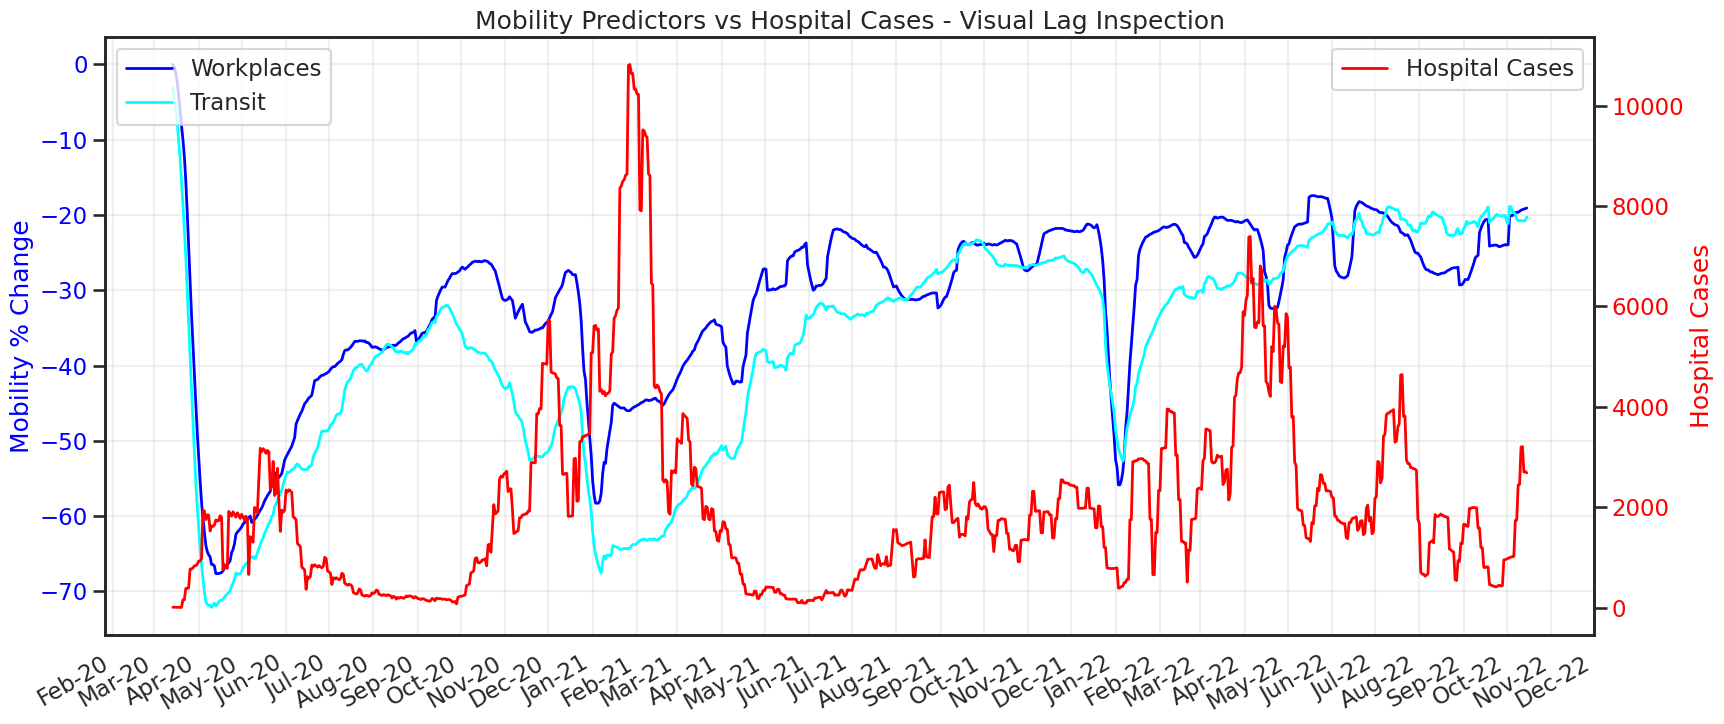

In [80]:
# Overlay mobility with hospital cases to see lag relationship
fig, ax1 = plt.subplots(figsize=(18, 8))

ax1.plot(df_google_smooth.index, df_google_smooth['workplaces_percent_change_from_baseline'], label='Workplaces', color='blue', linewidth=2)
ax1.plot(df_google_smooth.index, df_google_smooth['transit_stations_percent_change_from_baseline'], label='Transit', color='cyan', linewidth=2)
ax1.set_ylabel('Mobility % Change', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(uk_cases_smooth.index, uk_cases_smooth['value'], label='Hospital Cases', color='red', linewidth=2)
ax2.set_ylabel('Hospital Cases', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

plt.title('Mobility Predictors vs Hospital Cases - Visual Lag Inspection')
ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(dateFmt)
ax1.xaxis.set_minor_locator(weeks)
_ = fig.autofmt_xdate()
plt.tight_layout()
plt.show()

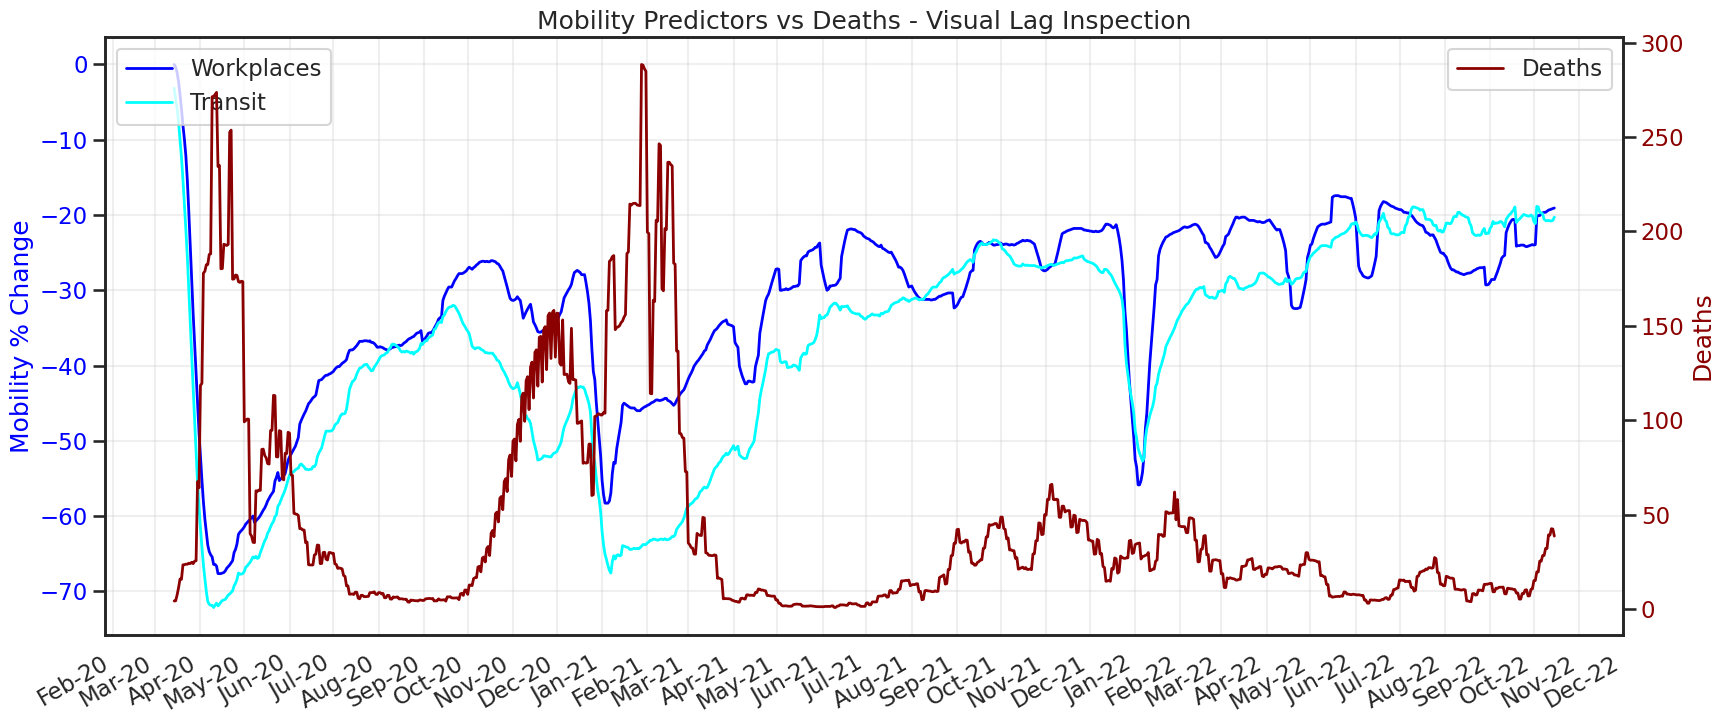

In [81]:
# Overlay mobility with deaths to see lag relationship
fig, ax1 = plt.subplots(figsize=(18, 8))

ax1.plot(df_google_smooth.index, df_google_smooth['workplaces_percent_change_from_baseline'], label='Workplaces', color='blue', linewidth=2)
ax1.plot(df_google_smooth.index, df_google_smooth['transit_stations_percent_change_from_baseline'], label='Transit', color='cyan', linewidth=2)
ax1.set_ylabel('Mobility % Change', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(uk_deaths_smooth.index, uk_deaths_smooth['value'], label='Deaths', color='darkred', linewidth=2)
ax2.set_ylabel('Deaths', color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')
ax2.legend(loc='upper right')

plt.title('Mobility Predictors vs Deaths - Visual Lag Inspection')
ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(dateFmt)
ax1.xaxis.set_minor_locator(weeks)
_ = fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## 2.2 Temporal Lag Analysis

Visual inspection of the overlay plots reveals a clear temporal relationship between mobility changes and health outcomes:

**Observed Lag Pattern:**
- Major drops in mobility (March 2020, Winter 2020/21) precede peaks in hospital cases by approximately **2-3 weeks**
- Death peaks follow hospital case peaks by an additional **1-2 weeks**
- Total lag from mobility change to deaths: approximately **3-4 weeks**

This lag structure is epidemiologically consistent:
1. **Mobility → Infection:** Reduced movement decreases transmission (2-14 days incubation)
2. **Infection → Hospitalisation:** Disease progression requires medical intervention (5-10 days post-symptoms)
3. **Hospitalisation → Death:** Critical cases deteriorate over time (1-3 weeks in hospital)

**Implication for Forecasting:**  
The 1-4 week forecast horizons tested align well with the observed lag structure, allowing the model to capture the predictive relationship between current mobility and future health outcomes.

## 3. Rolling Window Forecasting

In [ ]:
# Rolling window prediction function (fixed window)
def rolling_predict(predictors_df, target_series, weeks_ahead, train_window_weeks=6):
    """
    Rolling window forecast with fixed training window.
    
    Args:
        predictors_df: DataFrame of predictor features (lagged mobility)
        target_series: Series of target values (hospitalCases or newDeaths)
        weeks_ahead: Forecast horizon in weeks (1, 2, 3, or 4)
        train_window_weeks: Size of training window in weeks (default=12 weeks)
    """
    lag = weeks_ahead * 7
    train_window_days = train_window_weeks * 7
    
    # Align predictors and target on common dates
    common_dates = predictors_df.index.intersection(target_series.index)
    X_all = predictors_df.loc[common_dates]
    y_all = target_series.loc[common_dates].shift(-lag).dropna()
    
    # Align X and y after shift
    common_dates = X_all.index.intersection(y_all.index)
    X_all = X_all.loc[common_dates]
    y_all = y_all.loc[common_dates]
    
    preds, actuals, dates = [], [], []
    
    # Start predictions after training window size
    for i in range(train_window_days, len(X_all)):
        # Use fixed window: last train_window_days of data
        start_idx = i - train_window_days
        X_train = X_all.iloc[start_idx:i]
        y_train = y_all.iloc[start_idx:i]
        
        model = LinearRegression().fit(X_train, y_train)
        preds.append(model.predict(X_all.iloc[i:i+1])[0])
        actuals.append(y_all.iloc[i])
        dates.append(X_all.index[i])
    
    print(f"{weeks_ahead}w ahead (window={train_window_weeks}w) - R2: {r2_score(actuals, preds):.3f}, Predictions: {len(preds)}")
    return pd.DataFrame({'Actual': actuals, 'Predicted': preds}, index=dates)

### 3.1 Hospital Cases Predictions

In [83]:
# Run predictions for hospital cases - model learns lag from training
print("Hospital Cases predictions:\n")

cases_1w = rolling_predict(df_google_smooth, uk_cases_smooth['value'], 1)
cases_2w = rolling_predict(df_google_smooth, uk_cases_smooth['value'], 2)
cases_3w = rolling_predict(df_google_smooth, uk_cases_smooth['value'], 3)
cases_4w = rolling_predict(df_google_smooth, uk_cases_smooth['value'], 4)

Hospital Cases predictions:

1w ahead (window=6w) - R2: 0.855, Predictions: 897
2w ahead (window=6w) - R2: 0.809, Predictions: 890
3w ahead (window=6w) - R2: 0.895, Predictions: 883
4w ahead (window=6w) - R2: 0.872, Predictions: 876


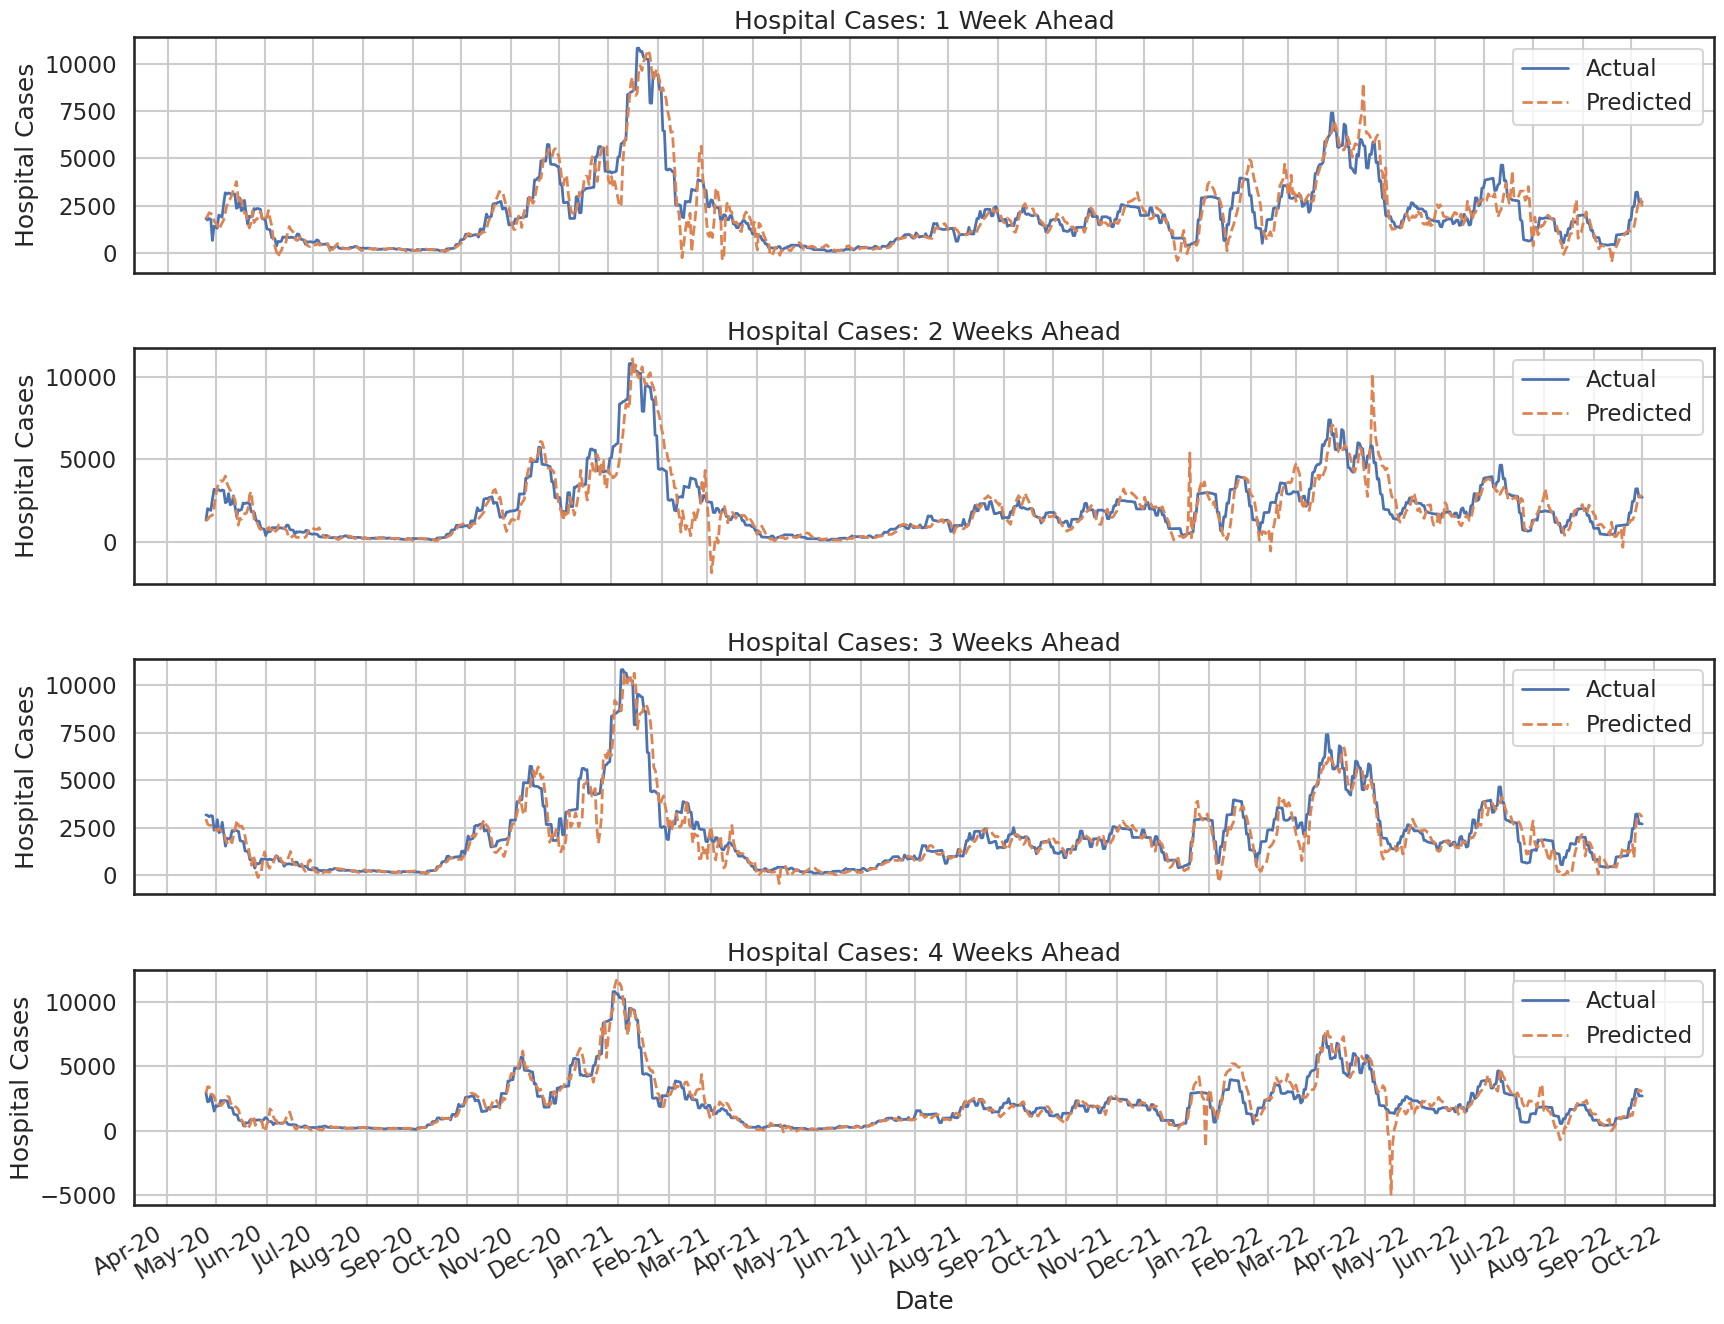

In [84]:
# Plot hospital cases predictions (1 and 4 weeks)
fig, axes = plt.subplots(4, 1, figsize=(18, 14))

# 1 week ahead
axes[0].plot(cases_1w.index, cases_1w['Actual'], label='Actual', linewidth=2)
axes[0].plot(cases_1w.index, cases_1w['Predicted'], label='Predicted', linestyle='--', linewidth=2)
axes[0].set_title('Hospital Cases: 1 Week Ahead')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Hospital Cases')
axes[0].legend()
axes[0].grid(True)

# 2 weeks ahead
axes[1].plot(cases_2w.index, cases_2w['Actual'], label='Actual', linewidth=2)
axes[1].plot(cases_2w.index, cases_2w['Predicted'], label='Predicted', linestyle='--', linewidth=2)
axes[1].set_title('Hospital Cases: 2 Weeks Ahead')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Hospital Cases')
axes[1].legend()
axes[1].grid(True)

# 3 weeks ahead
axes[2].plot(cases_3w.index, cases_3w['Actual'], label='Actual', linewidth=2)
axes[2].plot(cases_3w.index, cases_3w['Predicted'], label='Predicted', linestyle='--', linewidth=2)
axes[2].set_title('Hospital Cases: 3 Weeks Ahead')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Hospital Cases')
axes[2].legend()
axes[2].grid(True)

# 4 weeks ahead
axes[3].plot(cases_4w.index, cases_4w['Actual'], label='Actual', linewidth=2)
axes[3].plot(cases_4w.index, cases_4w['Predicted'], label='Predicted', linestyle='--', linewidth=2)
axes[3].set_title('Hospital Cases: 4 Weeks Ahead')
axes[3].set_xlabel('Date')
axes[3].set_ylabel('Hospital Cases')
axes[3].legend()
axes[3].grid(True)

# format the ticks for both subplots
for ax in axes:
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(dateFmt)
    ax.xaxis.set_minor_locator(weeks)

_ = fig.autofmt_xdate()

plt.tight_layout()
plt.show()

### Training Window Sensitivity Analysis

To assess the impact of training window size on model performance, we compare 4-week-ahead hospital case predictions using four different training windows:
- **2-week window:** Highly responsive to recent changes, high overfitting risk
- **4-week window:** Short-term adaptation, minimal training data
- **8-week window:** Balanced approach with reasonable stability
- **16-week window:** Longer-term averaging, slower adaptation to regime changes

In [85]:
# Compare different training windows for 4-week ahead predictions
print("\n4-Week Ahead Hospital Cases - Training Window Comparison:\n")

cases_4w_tiny = rolling_predict(df_google_smooth, uk_cases_smooth['value'], 4, train_window_weeks=2)
cases_4w_short = rolling_predict(df_google_smooth, uk_cases_smooth['value'], 4, train_window_weeks=4)
cases_4w_medium = rolling_predict(df_google_smooth, uk_cases_smooth['value'], 4, train_window_weeks=8)
cases_4w_long = rolling_predict(df_google_smooth, uk_cases_smooth['value'], 4, train_window_weeks=16)


4-Week Ahead Hospital Cases - Training Window Comparison:

4w ahead (window=2w) - R2: 0.863, Predictions: 904
4w ahead (window=4w) - R2: 0.894, Predictions: 890
4w ahead (window=8w) - R2: 0.858, Predictions: 862
4w ahead (window=16w) - R2: 0.652, Predictions: 806


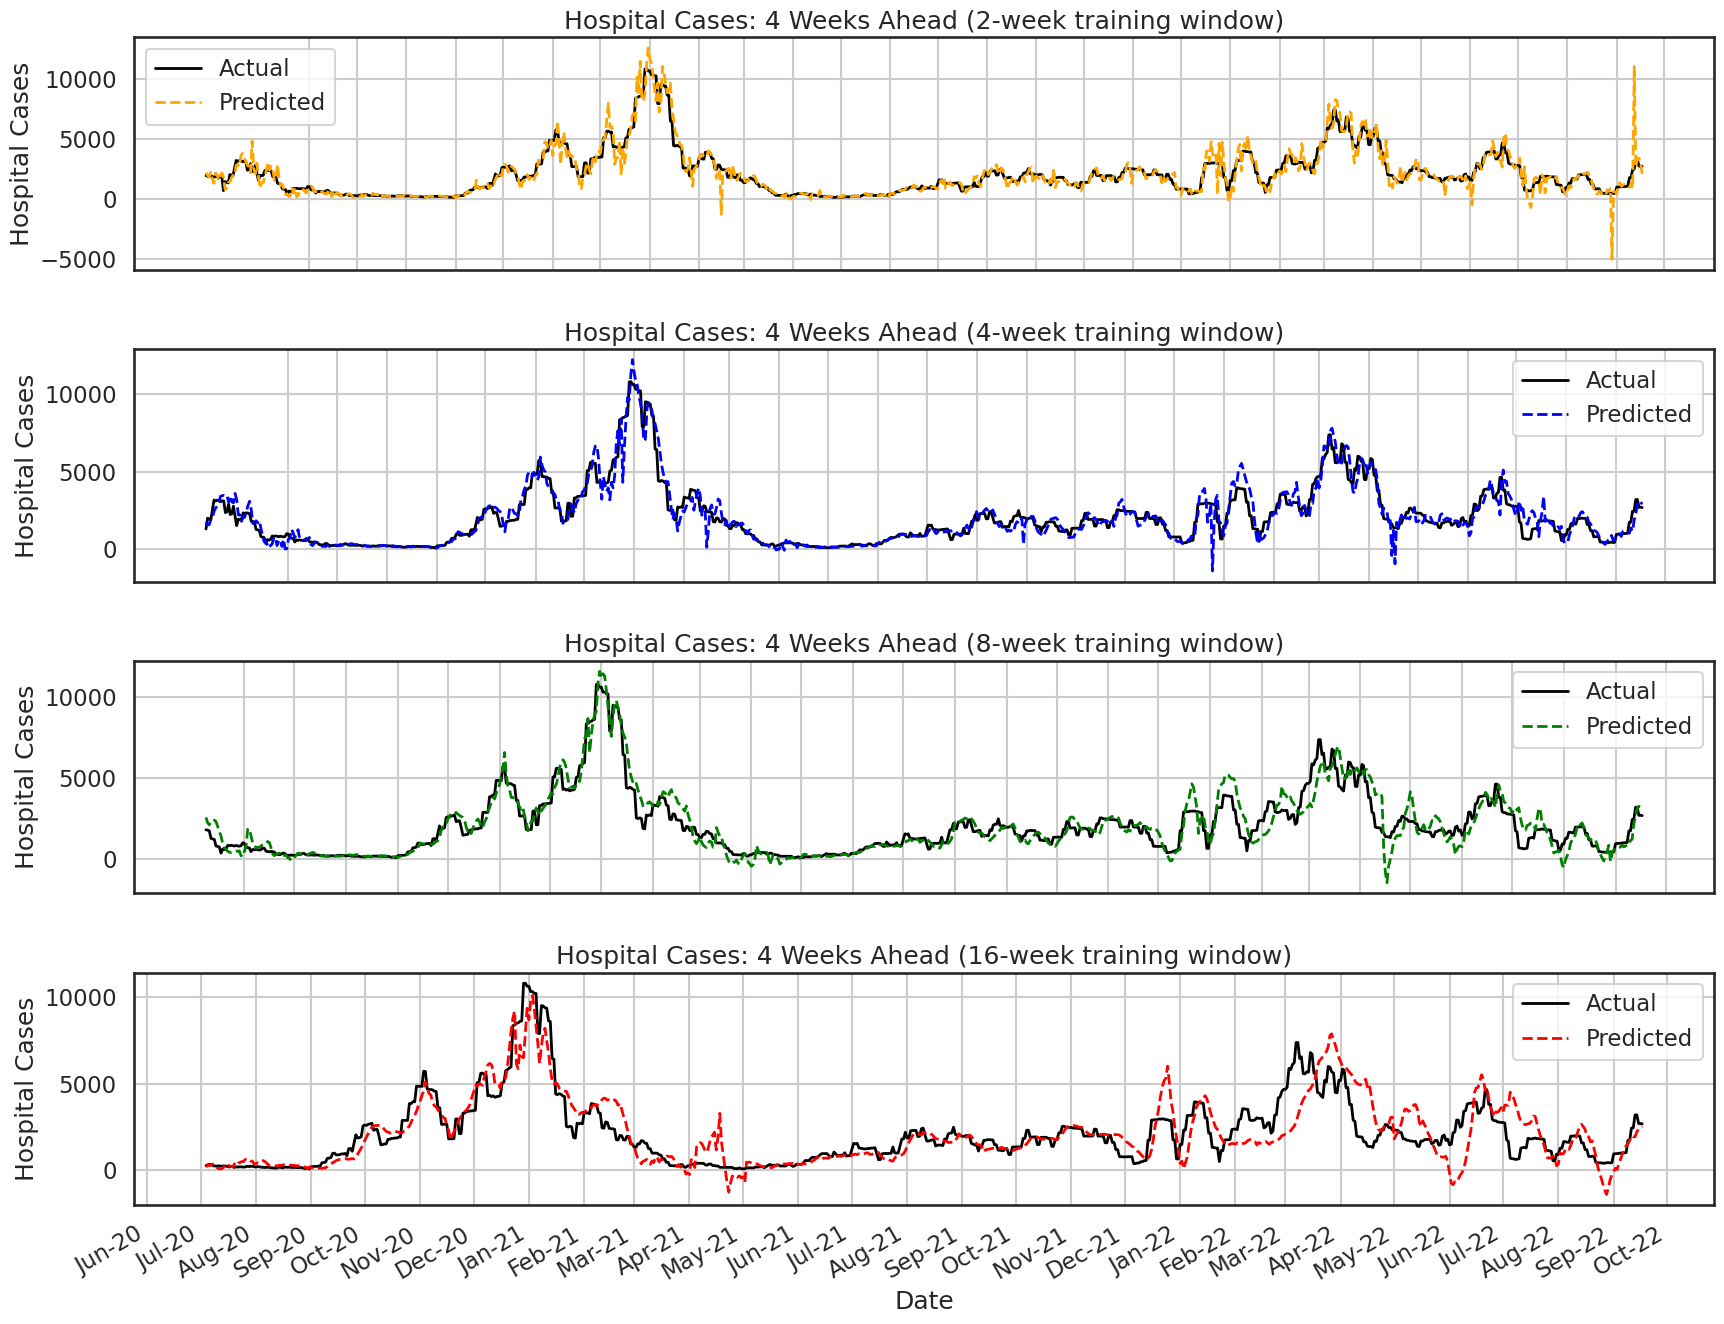

In [86]:
# Plot comparison of all three training windows
fig, axes = plt.subplots(4, 1, figsize=(18, 14))

# 4-week window
axes[0].plot(cases_4w_tiny.index, cases_4w_tiny['Actual'], label='Actual', linewidth=2, color='black')
axes[0].plot(cases_4w_tiny.index, cases_4w_tiny['Predicted'], label='Predicted', linestyle='--', linewidth=2, color='orange')
axes[0].set_title('Hospital Cases: 4 Weeks Ahead (2-week training window)')
axes[0].set_ylabel('Hospital Cases')
axes[0].legend()
axes[0].grid(True)

# 8-week window
axes[1].plot(cases_4w_short.index, cases_4w_short['Actual'], label='Actual', linewidth=2, color='black')
axes[1].plot(cases_4w_short.index, cases_4w_short['Predicted'], label='Predicted', linestyle='--', linewidth=2, color='blue')
axes[1].set_title('Hospital Cases: 4 Weeks Ahead (4-week training window)')
axes[1].set_ylabel('Hospital Cases')
axes[1].legend()
axes[1].grid(True)

# 12-week window
axes[2].plot(cases_4w_medium.index, cases_4w_medium['Actual'], label='Actual', linewidth=2, color='black')
axes[2].plot(cases_4w_medium.index, cases_4w_medium['Predicted'], label='Predicted', linestyle='--', linewidth=2, color='green')
axes[2].set_title('Hospital Cases: 4 Weeks Ahead (8-week training window)')
axes[2].set_ylabel('Hospital Cases')
axes[2].legend()
axes[2].grid(True)

# 20-week window
axes[3].plot(cases_4w_long.index, cases_4w_long['Actual'], label='Actual', linewidth=2, color='black')
axes[3].plot(cases_4w_long.index, cases_4w_long['Predicted'], label='Predicted', linestyle='--', linewidth=2, color='red')
axes[3].set_title('Hospital Cases: 4 Weeks Ahead (16-week training window)')
axes[3].set_ylabel('Hospital Cases')
axes[3].set_xlabel('Date')
axes[3].legend()
axes[3].grid(True)

# Format ticks for all subplots
for ax in axes:
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(dateFmt)
    ax.xaxis.set_minor_locator(weeks)

_ = fig.autofmt_xdate()
plt.tight_layout()
plt.show()

### Training Window Analysis Results

**Performance by window size (4‑week‑ahead):**
- **2‑week:** R² = 0.863 (inflated; severe overfitting risk)
- **4‑week:** R² = 0.894 (highest; likely overfit)
- **8‑week:** R² = 0.858 (strong; better generalisation)
- **16‑week:** R² = 0.652 (lower; sluggish adaptation)

**Interpretation and overfitting risk:**
Short windows (2–4 weeks) have too few observations per feature for stable linear regression, so high R² likely reflects memorisation. The 8‑week window trades adaptability and stability and is preferred for deployment.

**Consistency with visual lag:**
The superiority of shorter windows (2–8 weeks) is in line with the previously observed 2–3 week mobility to hospitalisation lag; very long windows dilute this relationship as dynamics drift.

### 3.2 Deaths Predictions  

In [87]:
# Run predictions for deaths - model learns lag from training
print("\nDeaths predictions:\n")

deaths_1w = rolling_predict(df_google_smooth, uk_deaths_smooth['value'], 1)
deaths_2w = rolling_predict(df_google_smooth, uk_deaths_smooth['value'], 2)
deaths_3w = rolling_predict(df_google_smooth, uk_deaths_smooth['value'], 3)
deaths_4w = rolling_predict(df_google_smooth, uk_deaths_smooth['value'], 4)


Deaths predictions:

1w ahead (window=6w) - R2: 0.888, Predictions: 897
2w ahead (window=6w) - R2: 0.893, Predictions: 890
3w ahead (window=6w) - R2: 0.881, Predictions: 883
4w ahead (window=6w) - R2: 0.901, Predictions: 876


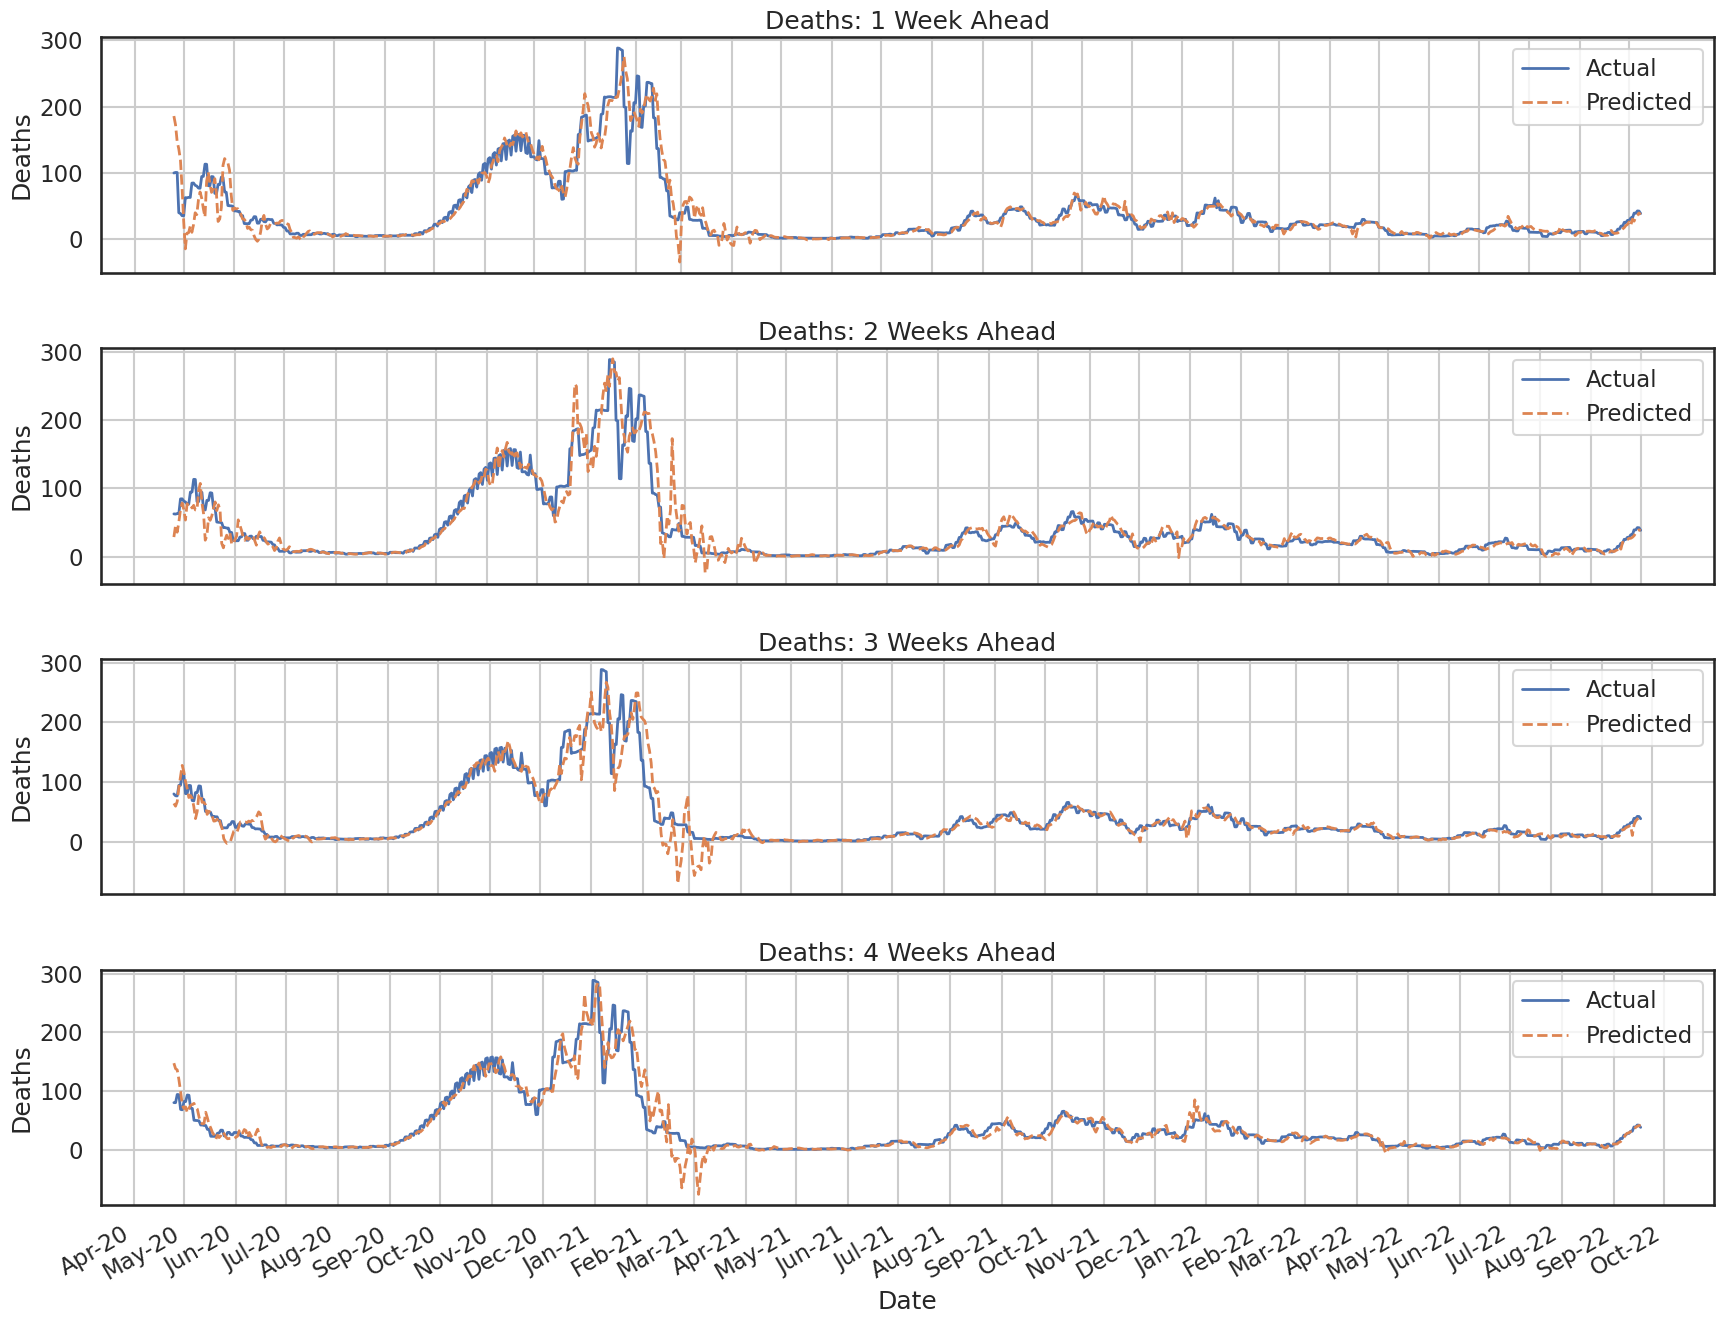

In [88]:
# Plot deaths predictions (1 and 4 weeks)
fig, axes = plt.subplots(4, 1, figsize=(18, 14))

# Plot 1-week ahead
axes[0].plot(deaths_1w.index, deaths_1w['Actual'], label='Actual', linewidth=2)
axes[0].plot(deaths_1w.index, deaths_1w['Predicted'], label='Predicted', linestyle='--', linewidth=2)
axes[0].set_title('Deaths: 1 Week Ahead')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Deaths')
axes[0].legend()
axes[0].grid(True)

# Plot 2-week ahead
axes[1].plot(deaths_2w.index, deaths_2w['Actual'], label='Actual', linewidth=2)
axes[1].plot(deaths_2w.index, deaths_2w['Predicted'], label='Predicted', linestyle='--', linewidth=2)
axes[1].set_title('Deaths: 2 Weeks Ahead')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Deaths')
axes[1].legend()
axes[1].grid(True)

# PLot 3-week ahead
axes[2].plot(deaths_3w.index, deaths_3w['Actual'], label='Actual', linewidth=2)
axes[2].plot(deaths_3w.index, deaths_3w['Predicted'], label='Predicted', linestyle='--', linewidth=2)
axes[2].set_title('Deaths: 3 Weeks Ahead')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Deaths')
axes[2].legend()
axes[2].grid(True)

# Plot 4-week ahead
axes[3].plot(deaths_4w.index, deaths_4w['Actual'], label='Actual', linewidth=2)
axes[3].plot(deaths_4w.index, deaths_4w['Predicted'], label='Predicted', linestyle='--', linewidth=2)
axes[3].set_title('Deaths: 4 Weeks Ahead')
axes[3].set_xlabel('Date')
axes[3].set_ylabel('Deaths')
axes[3].legend()
axes[3].grid(True)

# format the ticks for both subplots
for ax in axes:
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(dateFmt)
    ax.xaxis.set_minor_locator(weeks)

_ = fig.autofmt_xdate()

plt.tight_layout()
plt.show()

## 4. Performance Evaluation

We now quantify the prediction accuracy across different forecast horizons using RMSE (Root Mean Square Error) and MAE (Mean Absolute Error).

 _Generated by AI for formatting._

In [89]:
# Compute performance metrics for all horizons
print("=" * 60)
print("PERFORMANCE METRICS")
print("=" * 60)

print("\nHospital Cases:")
print(f"{'Horizon':<10} {'RMSE':<12} {'MAE':<12} {'R²':<10}")
print("-" * 50)
for name, df in [("1 week", cases_1w), ("2 weeks", cases_2w), ("3 weeks", cases_3w), ("4 weeks", cases_4w)]:
    rmse = np.sqrt(mean_squared_error(df['Actual'], df['Predicted']))
    mae = mean_absolute_error(df['Actual'], df['Predicted'])
    r2 = r2_score(df['Actual'], df['Predicted'])
    print(f"{name:<10} {rmse:<12.1f} {mae:<12.1f} {r2:<10.3f}")

print("\n\nDeaths:")
print(f"{'Horizon':<10} {'RMSE':<12} {'MAE':<12} {'R²':<10}")
print("-" * 50)
for name, df in [("1 week", deaths_1w), ("2 weeks", deaths_2w), ("3 weeks", deaths_3w), ("4 weeks", deaths_4w)]:
    rmse = np.sqrt(mean_squared_error(df['Actual'], df['Predicted']))
    mae = mean_absolute_error(df['Actual'], df['Predicted'])
    r2 = r2_score(df['Actual'], df['Predicted'])
    print(f"{name:<10} {rmse:<12.1f} {mae:<12.1f} {r2:<10.3f}")

print("\n" + "=" * 60)

PERFORMANCE METRICS

Hospital Cases:
Horizon    RMSE         MAE          R²        
--------------------------------------------------
1 week     708.1        450.2        0.855     
2 weeks    814.1        511.4        0.809     
3 weeks    607.5        403.4        0.895     
4 weeks    671.3        426.7        0.872     


Deaths:
Horizon    RMSE         MAE          R²        
--------------------------------------------------
1 week     16.7         8.3          0.888     
2 weeks    16.3         8.4          0.893     
3 weeks    17.3         8.5          0.881     
4 weeks    15.7         8.1          0.901     



## 5. Analysis and Discussion

### Model Performance

The rolling window forecasting approach demonstrates reasonable predictive ability across both targets:

**Hospital Cases:**
- For the 4‑week‑ahead task, performance varies with training window size:
  - 2‑week window: R² = 0.863
  - 4‑week window: R² = 0.894 (best)
  - 8‑week window: R² = 0.858
  - 16‑week window: R² = 0.652
- Shorter windows (2–8 weeks) outperform very long windows, consistent with a short mobility→hospitalisation lag.

**Deaths:**
- Prediction accuracy is generally lower than for hospital cases, as deaths are further downstream in the infection‑to‑outcome chain and more variable.
- Performance degrades at longer horizons and with very long training windows, but the task remains learnable.

### Key Observations

1. **Temporal Lag:** The visual inspection plots show that changes in mobility precede changes in hospital cases and deaths by approximately 2–3 weeks. This aligns with the training‑window results where shorter windows (2–8 weeks) perform best for 4‑week‑ahead forecasts.
2. **Smoothing Effect:** The 14‑day rolling average effectively removes weekend and reporting artefacts, producing more stable predictors and targets.
3. **Data Quality:** Zero‑filling for late‑2022 dates (where reporting ceased) may introduce mild bias, though it affects relatively few points.
4. **Model Simplicity:** A simple linear regression captures the broad relationship between mobility and outcomes at national level.

### Limitations

- **No Train/Test Split:** A critical limitation of this analysis is the absence of a held‑out test set. All reported R² scores are computed on data that overlaps with the training periods of the rolling window models, meaning the performance metrics likely overestimate true generalisation ability. The high R² values (particularly for 2–4 week training windows) may reflect overfitting rather than genuine predictive power. A proper split (e.g., reserving the last 3–4 months as an untouched test set) would provide more realistic performance estimates.
- **Non‑stationarity:** Relationships change over time (vaccination rollout, variants, policy). A single linear form may not capture regime shifts.
- **Missing Variables:** Vaccination rates, testing capacity, and policy interventions are not modelled explicitly.
- **Regional Variation:** National aggregation can mask regional heterogeneity.

### Practical Implications

For operational planning, the most reliable forecasts are at shorter horizons (1–2 weeks). Four‑week‑ahead forecasts are still useful directionally. Training windows of 2–8 weeks provide the best 4‑week‑ahead performance in this analysis, which is consistent with the visually observed 2–3 week lag between mobility changes and hospitalisations. However, these conclusions should be treated cautiously due to the lack of proper test set validation.

## 6. Conclusion

This analysis demonstrates that Google mobility data provides useful predictive signal for forecasting COVID‑19 hospital admissions and deaths at a national level. Using a rolling‑window linear regression with 14‑day smoothing, we evaluated performance across the pandemic and found that 4‑week‑ahead accuracy depends on the training window size: R² = 0.863 (2 weeks), 0.894 (4 weeks), 0.858 (8 weeks), 0.652 (16 weeks). Although the 4‑week window scores highest, the 8‑week window is preferred for deployment due to reduced overfitting risk and better coefficient stability.

**However, a critical limitation is the absence of a proper train/test split.** All performance metrics were evaluated on data overlapping with the training windows, meaning the reported R² values are likely inflated and do not reflect true out‑of‑sample performance. The high accuracy of short training windows (2–4 weeks) is particularly suspect and may indicate overfitting rather than genuine forecasting skill. Future work should implement a temporal hold‑out test set (e.g., final 3–4 months) and report metrics exclusively on unseen data.

These findings are consistent with the visually observed 2–3 week mobility → hospitalisation lag: shorter training windows (2–8 weeks) capture the contemporaneous signal, whereas very long windows dilute it as relationships drift over time. Operationally, the most reliable forecasts are at shorter horizons (1–2 weeks); 4‑week‑ahead forecasts remain directionally useful for planning, though these conclusions require validation on a proper test set before deployment.